# Lecture 20. CNN : MNIST



---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms

In [2]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Current device is', device)

# for reproducibility
torch.manual_seed(2023)
if device == 'cuda':
    torch.cuda.manual_seed_all(2023)

Current device is cuda


## 1. Data

MNIST

In [3]:
# MNIST dataset
mnist = datasets.MNIST(root='./data', train=True, download=True,
                       transform=transforms.ToTensor())

mnist_test = datasets.MNIST(root='./data', train=False, download=True, #test는 train=False
                            transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 164633461.68it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 118181164.71it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39025428.98it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21333178.91it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
# train validation split
mnist_train, mnist_val = torch.utils.data.random_split(mnist, [40000, 10000]) #데이터 나누기 (비율로 알려주기도 ㄱㄴ)

In [5]:
print('number of training data: ', len(mnist_train))
print('number of validation data: ', len(mnist_val))
print('number of test data: ', len(mnist_test))

number of training data:  50000
number of validation data:  10000
number of test data:  10000


In [8]:
img, label = mnist_train[0]
print(img.shape) #c=1, h=28, w=28 (흑백이므로 c=1)
print(label)

torch.Size([1, 28, 28])
1


In [9]:
batch_size = 100

# dataset loader (for mini-batch training)
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True) #train에서는 섞어서 가져오는게 좋음
val_loader = torch.utils.data.DataLoader(dataset=mnist_val,
                                         batch_size=batch_size,
                                         shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=len(mnist_test),  # 잘못 예측한 데이터 찾기 위해
                                          shuffle=False)

## 2. Model

In [10]:
# CNN Model (2 conv layers)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 1, 28, 28)
        #    Conv     -> (?, 32, 28, 28)
        #    Pool     -> (?, 32, 14, 14)
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 32, 14, 14)
        #    Conv      ->(?, 64, 14, 14)
        #    Pool      ->(?, 64, 7, 7)
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2))
        # FC (?, 64*7*7) inputs -> (?, 10) outputs
        self.fc = nn.Linear(64*7*7, 10)
        nn.init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them (?, 64*7*7) for FC
        out = self.fc(out)
        return out

In [11]:
# hyperparameters
learning_rate = 0.001
epochs = 20

# instantiate CNN model
model = CNN().to(device)

# define loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)


## 3. Training

In [15]:
train_batch = len(train_loader)
val_batch = len(val_loader)
print(train_batch, val_batch, sep='\n')

500
100


In [16]:
# train model
print('Learning started.')

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

best_val_loss = 10**9   # 큰 값으로 초기값 가정
patience_limit = 3    # 몇 번의 epoch까지 지켜볼지를 결정
patience_check = 0    # 현재 몇 epoch 연속으로 loss 개선 안되었는지 기록

for epoch in range(epochs):
    # training
    train_loss = 0
    correct = 0

    for X, Y in train_loader:
        # image is already size of (1, 28, 28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        Y_pred = model.forward(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss / train_batch

        correct_prediction = torch.argmax(Y_pred, 1) == Y
        correct += correct_prediction.sum()

    train_acc = (100*correct/len(train_loader.dataset))
    train_acc_list.append(train_acc.item())
    train_loss_list.append(train_loss.item())


    # validation
    with torch.no_grad():
        val_loss = 0
        correct = 0

        for X, Y in val_loader:
            X_val = X.to(device)
            Y_val = Y.to(device)

            Y_pred = model.forward(X_val)
            loss = criterion(Y_pred, Y_val)

            val_loss += loss / val_batch

            correct_prediction = torch.argmax(Y_pred, 1) == Y_val
            correct += correct_prediction.sum()

        val_acc = (100*correct/len(val_loader.dataset))
        val_acc_list.append(val_acc.item())
        val_loss_list.append(val_loss.item())

    print("[Epoch %2d] loss %.4f  acc %.2f, val loss %.4f  val acc %.2f"
          % (epoch+1, train_loss, train_acc, val_loss, val_acc))

    # early stopping
    if val_loss > best_val_loss: # loss가 개선되지 않은 경우
        patience_check += 1
        if patience_check >= patience_limit: # early stopping 조건 만족 시 조기 종료
            print('Early Stopping!')
            break
    else: # loss가 개선된 경우
        best_val_loss = val_loss
        patience_check = 0

print('Learning Finished!')

Learning started.
[Epoch  1] loss 0.2530  acc 92.37, val loss 0.0862  val acc 97.43
[Epoch  2] loss 0.0663  acc 98.06, val loss 0.0522  val acc 98.43
[Epoch  3] loss 0.0483  acc 98.51, val loss 0.0506  val acc 98.37
[Epoch  4] loss 0.0401  acc 98.76, val loss 0.0467  val acc 98.56
[Epoch  5] loss 0.0324  acc 99.00, val loss 0.0448  val acc 98.63
[Epoch  6] loss 0.0279  acc 99.08, val loss 0.0418  val acc 98.73
[Epoch  7] loss 0.0236  acc 99.26, val loss 0.0383  val acc 98.83
[Epoch  8] loss 0.0199  acc 99.39, val loss 0.0406  val acc 98.75
[Epoch  9] loss 0.0164  acc 99.47, val loss 0.0409  val acc 98.79
[Epoch 10] loss 0.0147  acc 99.52, val loss 0.0479  val acc 98.66
Early Stopping!
Learning Finished!


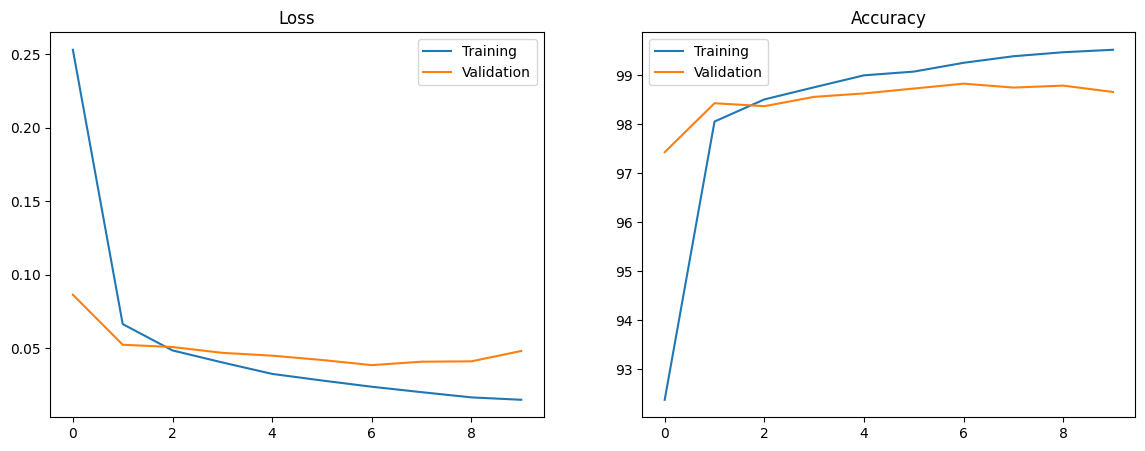

In [17]:
# plot loss and accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(range(len(train_loss_list)), train_loss_list, range(len(val_loss_list)), val_loss_list)
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(range(len(train_acc_list)), train_acc_list, range(len(val_acc_list)),val_acc_list)
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.show()

## Test Model

In [13]:
# Test model and check accuracy
with torch.no_grad():
    correct = 0
    # Test the model using test sets
    for X, Y in test_loader:
        X_test = X.to(device)
        Y_test = Y.to(device)

        Y_pred = model.forward(X_test)
        prediction = torch.argmax(Y_pred, 1)
        correct_prediction = prediction == Y_test
        correct += correct_prediction.sum()

    accuracy = 100*correct/len(test_loader.dataset)
    print('Test set Accuracy: %.2f' % (accuracy))

Test set Accuracy: 8.60


## Deeper Model

In [15]:
# CNN Model
class deepCNN(nn.Module):
    def __init__(self):
        super(deepCNN, self).__init__()
        self.drop_prob = 0.5
        # L1 ImgIn shape=(?, 1, 28, 28)
        #    Conv     -> (?, 32, 28, 28)
        #    Pool     -> (?, 32, 14, 14)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2))
        # L2 ImgIn shape=(?, 32, 14, 14)
        #    Conv      ->(?, 64, 14, 14)
        #    Pool      ->(?, 64, 7, 7)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(p=self.drop_prob)
            )
        # L3 ImgIn shape=(?, 64, 7, 7)
        #    Conv      ->(?, 128, 7, 7)
        #    Pool      ->(?, 128, 4, 4)
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1))

        # L4 FC (?, 128*4*4) inputs -> (?, 512) outputs
        self.fc1 = nn.Linear(128*4*4, 512)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=self.drop_prob))
        # L5 Final FC (?, 512) inputs -> (?, 10) outputs
        self.fc2 = nn.Linear(512, 10)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [16]:
# hyperparameters
learning_rate = 0.01
epochs = 15

# instantiate CNN model
model = deepCNN().to(device)

# define cost/loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.9)

In [17]:
print(model)

deepCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (layer4): 

In [18]:
# train model
print('Learning started.')

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    # training
    model.train()

    train_loss = 0
    correct = 0
    for X, Y in train_loader:
        # image is already size of (1, 28, 28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        Y_pred = model.forward(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        scheduler.step()   # learning rate scheduler

        train_loss += loss / train_batch

        correct_prediction = torch.argmax(Y_pred, 1) == Y
        correct += correct_prediction.sum()

    train_acc = (100*correct/len(train_loader.dataset))
    train_acc_list.append(train_acc.item())
    train_loss_list.append(train_loss.item())


    # validation
    with torch.no_grad():
        model.eval()

        val_loss = 0
        correct = 0

        for X, Y in val_loader:
            X_val = X.to(device)
            Y_val = Y.to(device)

            Y_pred = model.forward(X_val)
            loss = criterion(Y_pred, Y_val)

            val_loss += loss / val_batch

            correct_prediction = torch.argmax(Y_pred, 1) == Y_val
            correct += correct_prediction.sum()

        val_acc = (100*correct/len(val_loader.dataset))
        val_acc_list.append(val_acc.item())
        val_loss_list.append(val_loss.item())

    print("[Epoch %2d] loss %.4f  acc %.2f, val loss %.4f  val acc %.2f"
          % (epoch+1, train_loss, train_acc, val_loss, val_acc))
    print('lr', scheduler.get_last_lr())

print('Learning Finished!')

Learning started.


NameError: ignored

In [ ]:
# plot loss and accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_loss_list, range(1, epochs+1), val_loss_list)
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_acc_list, range(1, epochs+1), val_acc_list)
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.show()

In [ ]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()
    correct = 0
    # Test the model using test sets
    for X, Y in test_loader:
        X_test = X.to(device)
        Y_test = Y.to(device)

        Y_pred = model.forward(X_test)
        prediction = torch.argmax(Y_pred, 1)
        correct_prediction = prediction == Y_test
        correct += correct_prediction.sum()

    accuracy = 100*correct/len(test_loader.dataset)
    print('Test set Accuracy: %.2f' % (accuracy))

In [ ]:
false_list = []
for i, c in enumerate(correct_prediction):
    if c == False:
        false_list.append(i)

In [ ]:
r = 10
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(mnist_test.data[false_list[r+i]].view(28, 28).numpy(), cmap='gray')
    plt.title('label %d, prediction %d'
              %(mnist_test.targets[false_list[r+i]], prediction[false_list[r+i]]))
plt.show()

## Saving and Loading Model Weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CNN_weight.pt')

In [ ]:
# shape 정하기
my_model = deepCNN().to(device)
# weight 불러오기
my_model.load_state_dict(torch.load('/content/drive/MyDrive/CNN_weight.pt'))
my_model.eval() # be sure to call model.eval()
                # to set the dropout and batch normalization layers to evaluation mode.

In [ ]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()
    correct = 0
    # Test the model using test sets
    for X, Y in test_loader:
        X_test = X.view(-1, 1, 28, 28).to(device)
        Y_test = Y.to(device)

        Y_pred = model.forward(X_test)
        prediction = torch.argmax(Y_pred, 1)
        correct_prediction = prediction == Y_test
        correct += correct_prediction.sum()

    accuracy = 100*correct/len(test_loader.dataset)
    print('Test set Accuracy: %.2f' % (accuracy))

## Saving and Loading Models with Shapes

In [ ]:
torch.save(model, '/content/drive/MyDrive/CNN.pt')

In [ ]:
my_model_0 = torch.load('/content/drive/MyDrive/CNN.pt')
my_model_0.eval()

In [ ]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()
    correct = 0
    # Test the model using test sets
    for X, Y in test_loader:
        X_test = X.view(-1, 1, 28, 28).to(device)
        Y_test = Y.to(device)

        Y_pred = model.forward(X_test)
        prediction = torch.argmax(Y_pred, 1)
        correct_prediction = prediction == Y_test
        correct += correct_prediction.sum()

    accuracy = 100*correct/len(test_loader.dataset)
    print('Test set Accuracy: %.2f' % (accuracy))